In [1]:
from sibyl_cpp import snake
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
import time

In [2]:
#warning! doesnt check particle ID!

min_pmt_hits=0

labels=['x','y','z','zenith','azimuth','t','energy']
sn = snake()
event_range=[]
for i in range(1,2):
    sn.openFile("/data/abald/no_noise/"+str(i)+".root")
#    for event in range(0,sn.getEntries()):
    for event in range(0,100):
        sn.getEvent(event)
        charges, times = sn.getHitInfo()
        PMT_id=sn.getID()
        pmts=np.where(times>-100)[0] #get index of nonzero values
        if (len(pmts) > 0 and len(np.where(PMT_id[pmts]==1)[0]) > min_pmt_hits):
            sn.getMCTruth()
            x,y,z=sn.getXYZ()
            p=np.column_stack(sn.getMCVal())
            zenith = math.acos(p[0,5]/np.linalg.norm(p[0,3:6],2))
            azimuth = math.atan2(p[0,4], p[0,3])+3.141592654
            p=np.column_stack((p[0,0],p[0,1],p[0,2],zenith,azimuth,p[0,6],p[0,7]))
            new_params = np.repeat(p, len(pmts), axis=0)
            new_hits = np.column_stack((x[pmts],y[pmts],z[pmts],times[pmts],charges[pmts],PMT_id[pmts]))
      
            try:
                hits=np.row_stack((hits,new_hits))
                params=np.row_stack((params,new_params))

            except:
                hits=new_hits
                params=new_params
                
            try:
                event_range.append((event_range[-1][-1],event_range[-1][-1]+len(pmts)))
            except:
                event_range=[(0,len(pmts))]


    try:
        totalhits=np.row_stack((totalhits,hits))
        totalparams=np.row_stack((totalparams,params))
        print(totalhits.shape)
        print(totalparams.shape)
        del hits,params    
    except:
        totalhits=hits
        totalparams=params
        print(totalhits.shape)
        print(totalparams.shape)
        del hits,params 
        print('exception')
    print(str(i)+" runs have been completed")

/data/abald/no_noise/1.root
(910, 6)
(910, 7)
exception
1 runs have been completed


In [20]:
evt=0

print(totalparams[evt])

#print(totalhits[event_range[0][0]:event_range[0][1]])
event={
    'hits': totalhits[event_range[evt][0]:event_range[evt][1]],
    'truth': totalparams[event_range[evt][0]]
}
print(totalhits[event_range[evt][0]:event_range[evt][1]][:,3])
from scipy.optimize import least_squares

def get_residuals(x,event):
    #input vector x corresponds to [x,y,z,t]
    residuals=[]
    c=299792458*10**-6
    n=1.333
    #takes an event hit and calculates residuals
    for i in range (0,len(event['hits'])):
        hit=event['hits'][i]
        residuals.append((c/n)**2 *(x[3]-hit[3])**2 - (x[0]-hit[0])**2 - (x[1]-hit[1])**2 - (x[2]-hit[2])**2)
    return np.array(residuals)


truth=event['truth'][[0,1,2,5]]
get_residuals(truth,event)

bound=([-6700,-6700,-6700,-100],[6700,6700,6700,0])

x0=np.array([0,0,0,-10 ])
returned=least_squares(get_residuals,x0,args=(event,),bounds=bound)
print(returned['x'])
print(event['hits'][1][0:4])
print(truth)
print(event['hits'][1][0:4]-truth)


[-1.42338856e+03 -1.22063346e+02 -6.24805765e+03  7.07414504e-02
  2.48184910e+00 -6.10506050e+01  2.98344660e+00]
[[-3.35000000e+03 -5.80237021e+03 -2.50000000e+02  2.10212892e+01
   1.09528303e+00  1.00000000e+00]
 [ 1.97485967e+03 -6.40233780e+03  2.50000000e+02  5.69393780e+01
   1.28326011e+00  1.00000000e+00]
 [-3.35000000e+03 -5.80237021e+03 -7.50000000e+02 -2.26095966e+01
   7.36111879e-01  1.00000000e+00]
 [-6.03649141e+03  2.90702105e+03  3.25000000e+03 -7.75447646e+00
   8.68860960e-01  1.00000000e+00]
 [-9.98583183e+02  6.62516654e+03  4.25000000e+03  0.00000000e+00
   5.14313221e-01  1.00000000e+00]
 [-4.17738167e+03 -5.23827093e+03 -4.25000000e+03 -3.40415207e+01
   8.16748202e-01  1.00000000e+00]
 [-6.62516654e+03 -9.98583183e+02 -4.75000000e+03 -3.40759222e+01
   9.25938487e-01  1.00000000e+00]
 [ 9.98583183e+02 -6.62516654e+03 -5.75000000e+03 -2.60076499e+01
   7.42623150e-01  1.00000000e+00]]
[-2.98556421e+03  1.37541877e+03 -5.33869939e+02 -1.73776700e-24]
[ 1974.859

In [6]:
np.save('noisedata/3kHz/hits_eval',totalhits)
np.save('noisedata/3kHz/params_eval',totalparams)
np.save('noisedata/3kHz/event_eval',event_range)

In [7]:


end_range=[i[1] for i in event_range]
start_range=[i[0] for i in event_range]
event_charge=np.zeros([len(end_range),2],np.float32)
charge_params=np.zeros([len(end_range),7],np.float32)
start=start_range[i]

print(event_charge[0,0])

for i in range(0,len(start_range)):
    start=start_range[i]
    end=end_range[i]
#    try:
    num_pmts=end-start
    event_charge[i,0]=np.sum(totalhits[start:end,4])
    event_charge[i,1]=num_pmts
    charge_params[i]=totalparams[start]
#    except:
#    event_charge=totalhits[start:end,4]
#    charge_params=totalparams[start]
    if i%50000==0:
        print(str(100*i/len(end_range))+'% complete')

    




0.0
0.0% complete
9.78849030156381% complete
19.57698060312762% complete
29.365470904691428% complete
39.15396120625524% complete
48.942451507819044% complete
58.730941809382855% complete
68.51943211094667% complete
78.30792241251048% complete
88.09641271407428% complete
97.88490301563809% complete


In [8]:
print(np.shape(event_charge))
print(np.shape(charge_params))
np.save('noisedata/3kHz/charge_eval',event_charge)
np.save('noisedata/3kHz/event_eval',charge_params)

(510804, 2)
(510804, 7)


In [ ]:
print(np.column_stack((p[0,0],p[0,1],p[0,2],zenith,azimuth,p[0,6],p[0,7])))
print(zenith)
print(azimuth)

In [176]:
i=3277045
start=event_range[i][0]
end=event_range[i][1]
print(event_charge[i])
print(charge_params[i])

print(totalhits[start:end])
print('-------diagnostics')
print('start')
print(start_range[i])
print('end')
print(end_range[i])
print('number of pmts')
print(end-start)
print('total charge')
print(np.sum(totalhits[start:end,4]))
print('parameters')
print(totalparams[start_range[i]])
print(np.where((event_charge > 46.79742) & (event_charge < 46.797439)))

[46.797432 21.      ]
[-4.8416470e+03 -3.5249265e+03  4.5541465e+03  1.5557884e+00
  9.2407010e-02 -3.5885561e+00  7.4088492e+00]
[[-6.62516654e+03 -9.98583183e+02  2.75000000e+03  1.43266928e+01
   1.34318042e+00  1.00000000e+00]
 [-5.80237021e+03 -3.35000000e+03  2.75000000e+03  7.15761002e+00
   1.14567101e+00  1.00000000e+00]
 [-5.80237021e+03 -3.35000000e+03  3.25000000e+03  4.60444249e+00
   1.22798753e+00  1.00000000e+00]
 [-5.53579979e+03 -3.77424439e+03  3.25000000e+03  7.33160255e+01
   1.10084021e+00  1.00000000e+00]
 [-6.23685412e+03 -2.44778486e+03  3.75000000e+03  5.87756307e+00
   1.48232687e+00  1.00000000e+00]
 [-5.80237021e+03 -3.35000000e+03  3.75000000e+03  2.80836821e+00
   1.29416728e+00  1.00000000e+00]
 [-5.53579979e+03 -3.77424439e+03  3.75000000e+03 -3.74372321e-01
   7.71822643e+00  1.00000000e+00]
 [-5.23827093e+03 -4.17738167e+03  3.75000000e+03  8.95475861e-01
   2.24119115e+00  1.00000000e+00]
 [-6.03649141e+03 -2.90702105e+03  4.25000000e+03  3.12636499e

In [150]:
event_range[i][0]

0

In [ ]:
totalhits=np.load('testhits2.npy')
event_range=np.load('testevent_num2.npy')
params=np.load('testparams2.npy')


In [ ]:
nbins=50
param_num=5
title='PMT Time Hit'
xlabel='ns'
ylabel='p(t)'

hist,bin_edges=np.histogram(totalparams[:,param_num],bins=nbins,density=True)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
plt.xlim(min(bin_edges), max(bin_edges))
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.show()


In [ ]:
nbins=18
param_num=3
title='Probability Distribution of PMT Hits during Event'
xlabel='Number of Veto PMTs Hit'
ylabel='Probability'

hist,bin_edges=np.histogram(x,bins=nbins,density=True)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
plt.xlim(min(bin_edges), 75)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.rcParams["figure.facecolor"] = 'white'
plt.show()


In [ ]:
#for veto pmts
x=np.zeros(len(event_range))
event=0
for i in event_range:
    for j in range(i[0],i[1]):
        if(totalhits[j,5]==2):
            x[event]+=1
    event+=1

In [ ]:
#for regular pmts
y=np.zeros(len(event_range))
event=0
for i in event_range:
    for j in range(i[0],i[1]):
        if(totalhits[j,5]==1):
            y[event]+=1
    event+=1

In [ ]:
totalhits=np.load('testhits.npy')
totalparams=np.load('testparams.npy')
event_range=np.load('event_num.npy')

In [ ]:
nbins=61
param_num=3
title='Probability Distribution of Inner PMT Hits during Event'
xlabel='Number of Inner PMTs Hit'
ylabel='Probability'

hist,bin_edges=np.histogram(y,bins=nbins,density=True)

width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
plt.xlim(20, max(bin_edges))
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.rcParams["figure.facecolor"] = 'white'
plt.show()


In [ ]:
print (bin_edges)

# Import Bonsai and other data, Then compare

In [ ]:
bonsailoc="compare.root"
d = ROOT.RDataFrame("data", bonsailoc)
s=d.Filter("inner_hit>9")
bonsaievents=s.AsNumpy()
hitman=np.load('1kevalnoise.npy')
params=np.load('testparams2.npy')
ids=np.load('testevent_num2.npy')

In [ ]:
event=0
truth=params[ids[event][0]][0:1]
truth=params[0][2]
x_hm=hitman[event,2]-truth
x_bs=(bonsaievents['z'][event]-truth)
correction=0

for event in range(1,1000):
    if abs(bonsaievents['mcx'][event]-params[ids[event-correction][0]][0])<0.0001:
        x_hm=np.hstack([x_hm,hitman[event,2]-params[ids[event][0]][2]])
        x_bs=np.hstack([x_bs,bonsaievents['z'][event]-params[ids[event-correction][0]][2]])
    else:
        correction+=1

In [ ]:
nbins=100
param_num=5
title='Bonsai Reconstruction - MC Truth (z)'
xlabel='Distance: mm'
ylabel='Events'

hist,bin_edges=np.histogram(x_bs,bins=nbins,density=False)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
plt.xlim(-2000, 2000)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.show()
print(np.std(x_bs))
print(np.average(x_bs))

In [ ]:
nbins=200
param_num=5
title='Hitman Reconstruction - MC Truth (z)'
xlabel='Distance mm'
ylabel='events'

hist,bin_edges=np.histogram(x_hm,bins=nbins,density=False)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
plt.xlim(-2500, 2500)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.show()
print(np.std(x_hm))
print(np.average(x_hm))

In [ ]:
event=43
print(bonsaievents['mcx'][event+1])
print(params[ids[event][0]][0])
print((x_bs))

In [ ]:
nbins=17
param_num=5
title='Noise Distribution'
xlabel='Probability'
ylabel='number of noise hits'

hist,bin_edges=np.histogram(np.random.poisson(1000*3258*1500*1e-9, 50000),bins=nbins,density=True)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
#plt.xlim(-2500, 2500)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.show()


In [ ]:
np.random.poisson(1000*3258*1500*1e-9, 1)[0]

In [ ]:
nbins=200
param_num=5
title='Hitman Reconstruction - MC Truth (z)'
xlabel='Distance mm'
ylabel='events'

hist,bin_edges=np.histogram(x_hm,bins=nbins,density=False)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
plt.xlim(-2000, 2000)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.show()
print(np.std(x_hm))
print(np.average(x_hm))

In [ ]:
np.min(x_hm)

In [2]:
min_pmt_hits=0

labels=['x','y','z','zenith','azimuth','t','energy']
sn = snake()
event_range=[]
i=1
sn.openFile("/data/abald/3kHz"+str(i)+".root")
event=1100
sn.getEvent(event)
charges, times = sn.getHitInfo()
PMT_id=sn.getID()
pmts=np.where(times>-100)[0] #get index of nonzero values
if (len(pmts) > 0 and len(np.where(PMT_id[pmts]==1)[0]) > min_pmt_hits):
    sn.getMCTruth()
    x,y,z=sn.getXYZ()
    p=np.column_stack(sn.getMCVal())
    zenith = math.acos(p[0,5]/np.linalg.norm(p[0,3:6],2))
    azimuth = math.atan2(p[0,4], p[0,3])
    p=np.column_stack((p[0,0],p[0,1],p[0,2],zenith,azimuth,p[0,6],p[0,7]))
    new_params = np.repeat(p, len(pmts), axis=0)
    new_hits = np.column_stack((x[pmts],y[pmts],z[pmts],times[pmts],charges[pmts],PMT_id[pmts]))

    try:
        hits=np.row_stack((hits,new_hits))
        params=np.row_stack((params,new_params))

    except:
        hits=new_hits
        params=new_params

    try:
        event_range.append((event_range[-1][-1],event_range[-1][-1]+len(pmts)))
    except:
        event_range=[(0,len(pmts))]




~/testbench/utilInstall/WMUtils/sibyl/3kHz/1.root


In [129]:
event=2
i=event
end=end_range[i]
start=start_range[i]
print(start)
print(end)
print(totalhits[start:end,0])
print('integrated')
print(np.sum(totalhits[start:end,0]))
print('tot hit')
print(end-start)

18
33
[-2.44778486e+03 -9.98583183e+02 -4.17738167e+03 -9.98583183e+02
  4.10256678e-13 -1.49089026e+03  4.10256678e-13 -5.00691627e+02
 -2.90702105e+03  5.00691627e+02  4.10256678e-13 -5.00691627e+02
 -9.98583183e+02 -1.49089026e+03 -1.49089026e+03]
integrated
-17501.29953748807
tot hit
15


# Lets try and understand the probability of energies given charge

1.002421676732932


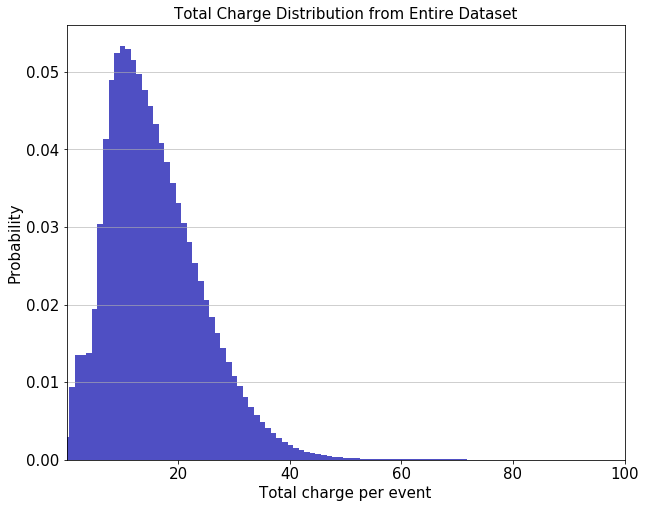

0.9811320754716981


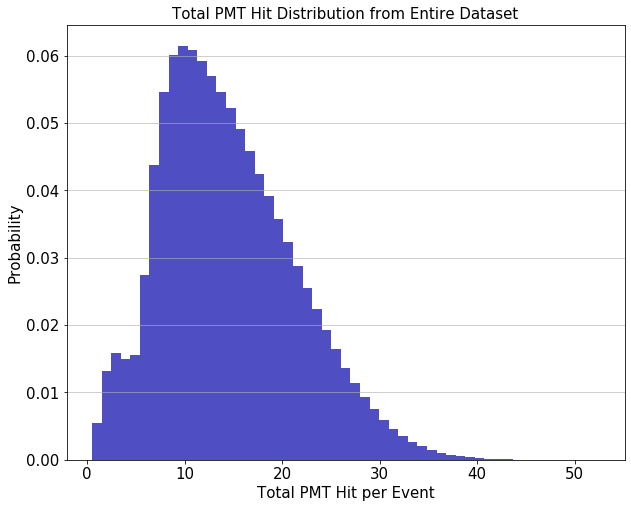

0.12999987602233887


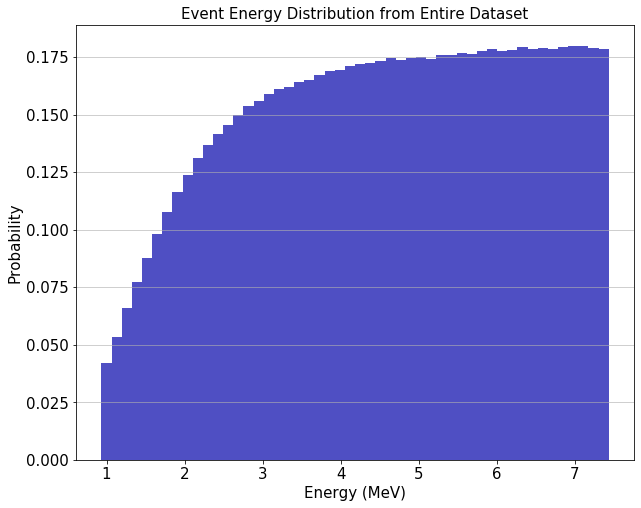

In [215]:
#What is the total charge distribution?
nbins=314
param_num=3
title='Total Charge Distribution from Entire Dataset'
xlabel='Total charge per event'
ylabel='Probability'

hist,bin_edges=np.histogram(event_charge[:,0],bins=nbins,density=True)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
plt.xlim(min(bin_edges), 100)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.rcParams["figure.facecolor"] = 'white'
plt.show()

#What is the total PMT hit distribution

nbins=53
param_num=3
title='Total PMT Hit Distribution from Entire Dataset'
xlabel='Total PMT Hit per Event'
ylabel='Probability'

hist,bin_edges=np.histogram(event_charge[:,1],bins=nbins,density=True)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
#plt.xlim(min(bin_edges), 75)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.rcParams["figure.facecolor"] = 'white'
plt.show()


#What is the total energy distribution?
nbins=50
param_num=6
title='Event Energy Distribution from Entire Dataset'
xlabel='Energy (MeV)'
ylabel='Probability'

hist,bin_edges=np.histogram(charge_params[:,6],bins=nbins,density=True)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
#plt.xlim(min(bin_edges), 10)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.rcParams["figure.facecolor"] = 'white'
plt.show()

0.12999872207641602


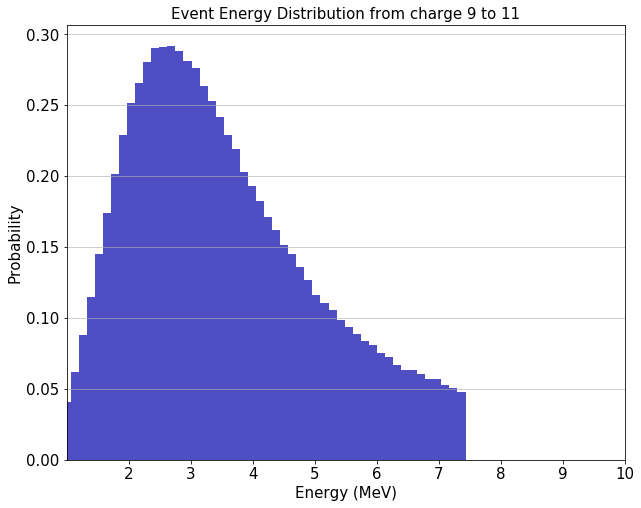

0.12983935356140136


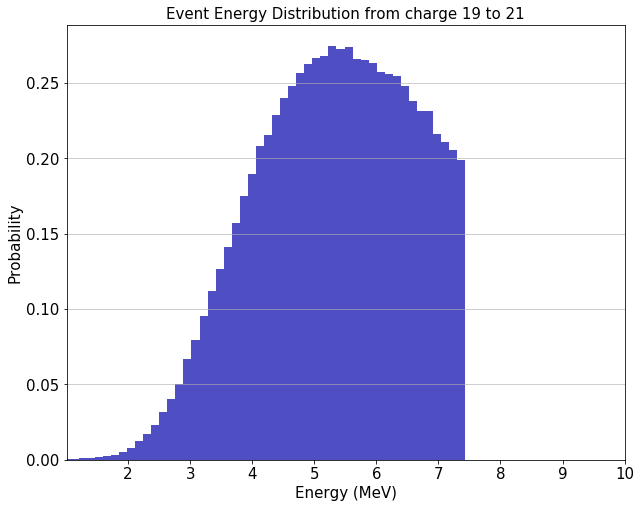

0.12901519775390624


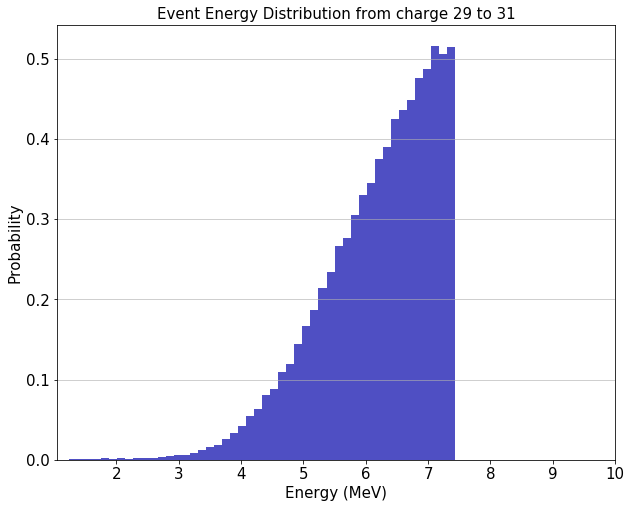

In [203]:
Q_low=9
Q_high=11
indices=(np.where((event_charge[:,0]<Q_high) & (event_charge[:,0]>Q_low)))
#What is the total charge distribution?
nbins=50
param_num=6
title='Event Energy Distribution from charge '+str(Q_low)+' to '+str(Q_high)
xlabel='Energy (MeV)'
ylabel='Probability'

hist,bin_edges=np.histogram(charge_params[indices,6],bins=nbins,density=True)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
plt.xlim(min(bin_edges), 10)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.rcParams["figure.facecolor"] = 'white'
plt.show()
#######################
Q_low=19
Q_high=21
indices=(np.where((event_charge[:,0]<Q_high) & (event_charge[:,0]>Q_low)))
#What is the total charge distribution?
nbins=50
param_num=6
title='Event Energy Distribution from charge '+str(Q_low)+' to '+str(Q_high)
xlabel='Energy (MeV)'
ylabel='Probability'

hist,bin_edges=np.histogram(charge_params[indices,6],bins=nbins,density=True)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
plt.xlim(min(bin_edges), 10)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.rcParams["figure.facecolor"] = 'white'
plt.show()
#######################
Q_low=29
Q_high=31
indices=(np.where((event_charge[:,0]<Q_high) & (event_charge[:,0]>Q_low)))
#What is the total charge distribution?
nbins=50
param_num=6
title='Event Energy Distribution from charge '+str(Q_low)+' to '+str(Q_high)
xlabel='Energy (MeV)'
ylabel='Probability'

hist,bin_edges=np.histogram(charge_params[indices,6],bins=nbins,density=True)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
plt.xlim(min(bin_edges), 10)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.rcParams["figure.facecolor"] = 'white'
plt.show()

0.12999707221984863


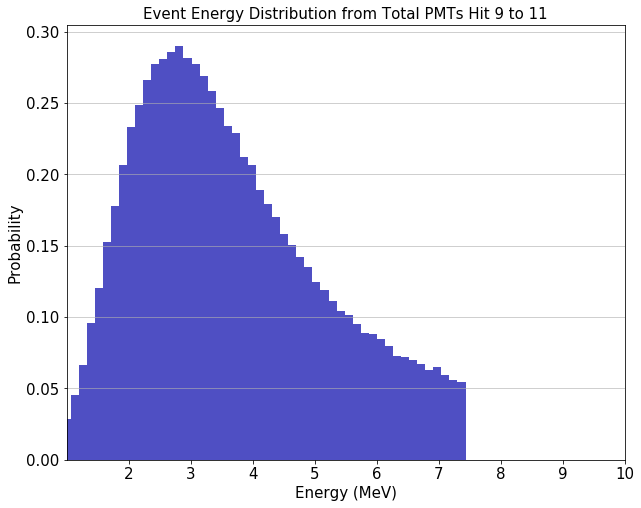

0.12660839080810546


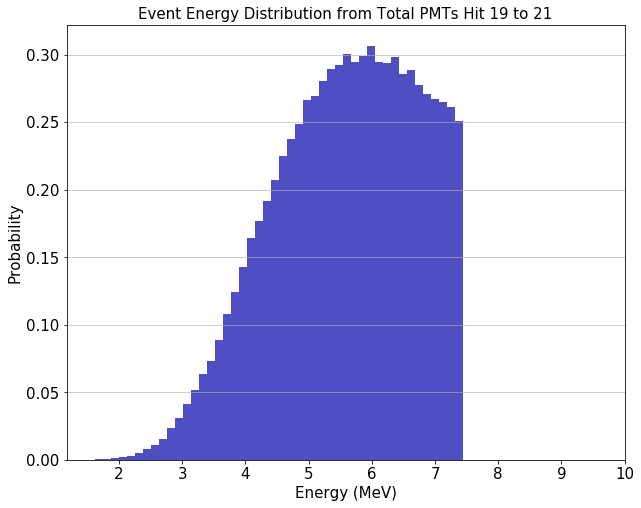

0.09014663696289063


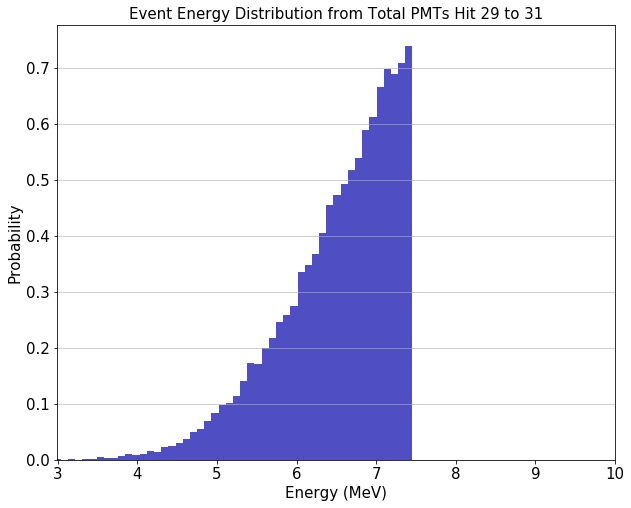

In [220]:
PMT_low=9
PMT_high=11
indices=(np.where((event_charge[:,1]<PMT_high) & (event_charge[:,1]>PMT_low)))
#What is the total charge distribution?
nbins=50
param_num=6
title='Event Energy Distribution from Total PMTs Hit '+str(PMT_low)+' to '+str(PMT_high)
xlabel='Energy (MeV)'
ylabel='Probability'

hist,bin_edges=np.histogram(charge_params[indices,6],bins=nbins,density=True)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
plt.xlim(min(bin_edges), 10)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.rcParams["figure.facecolor"] = 'white'
plt.show()

PMT_low=19
PMT_high=21
indices=(np.where((event_charge[:,1]<PMT_high) & (event_charge[:,1]>PMT_low)))
#What is the total charge distribution?
nbins=50
param_num=6
title='Event Energy Distribution from Total PMTs Hit '+str(PMT_low)+' to '+str(PMT_high)
xlabel='Energy (MeV)'
ylabel='Probability'

hist,bin_edges=np.histogram(charge_params[indices,6],bins=nbins,density=True)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
plt.xlim(min(bin_edges), 10)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.rcParams["figure.facecolor"] = 'white'
plt.show()

PMT_low=29
PMT_high=31
indices=(np.where((event_charge[:,1]<PMT_high) & (event_charge[:,1]>PMT_low)))
#What is the total charge distribution?
nbins=50
param_num=6
title='Event Energy Distribution from Total PMTs Hit '+str(PMT_low)+' to '+str(PMT_high)
xlabel='Energy (MeV)'
ylabel='Probability'

hist,bin_edges=np.histogram(charge_params[indices,6],bins=nbins,density=True)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
plt.xlim(min(bin_edges), 10)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.rcParams["figure.facecolor"] = 'white'
plt.show()

In [4]:
event_charge=np.load('noisedata/3kHzcharge.npy')
charge_params=np.load('noisedata/3kHzevent_1param.npy')

368.0880859375


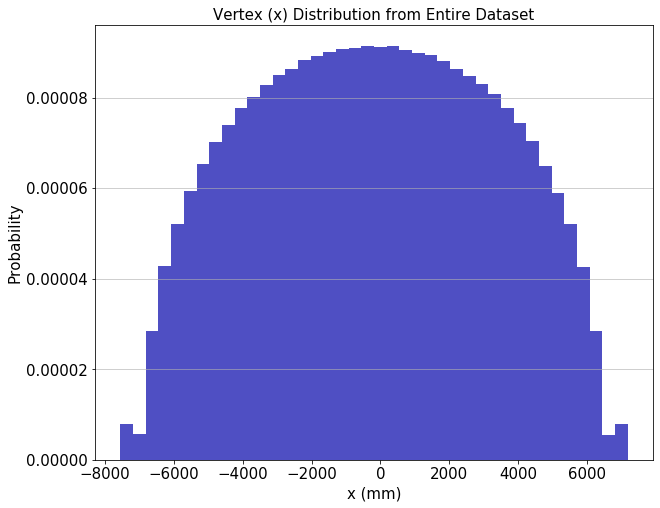

368.0841552734375


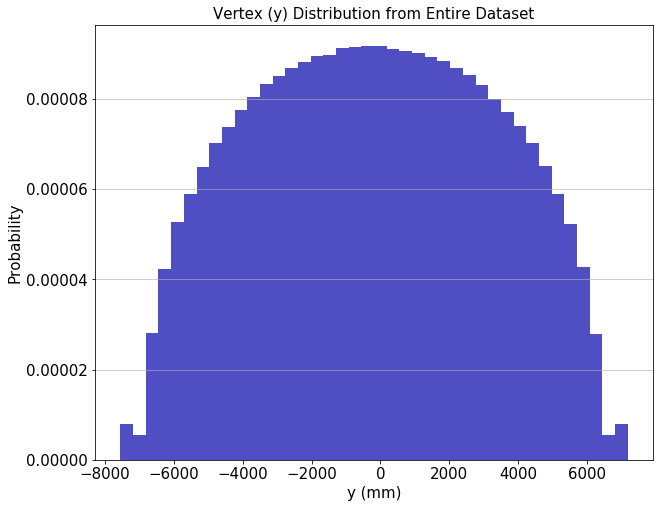

334.9986328125


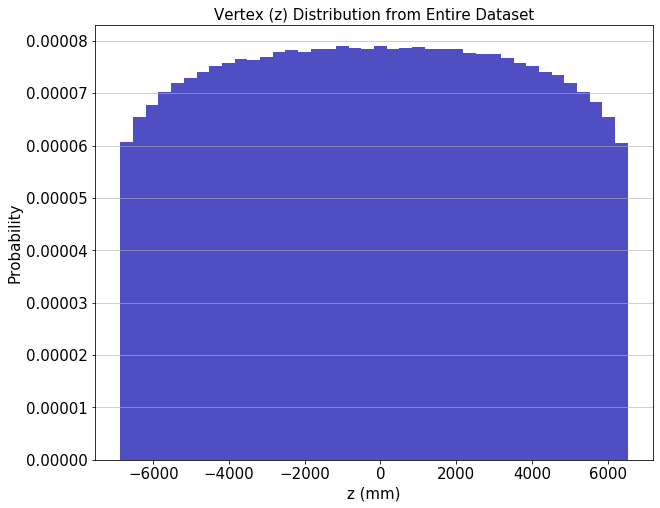

0.07848835587501526


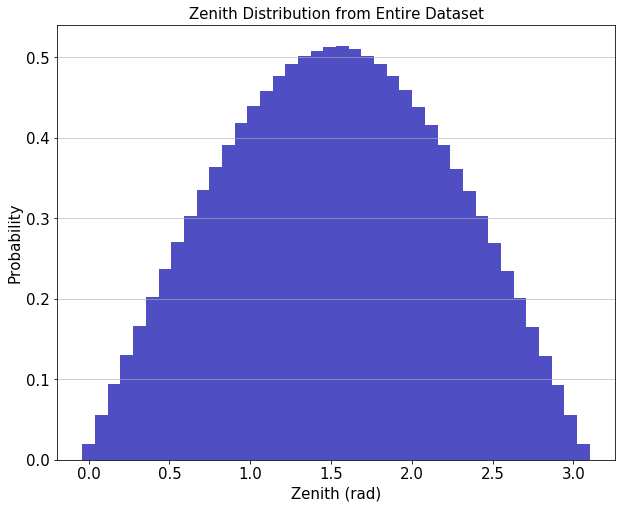

5.7372841796875


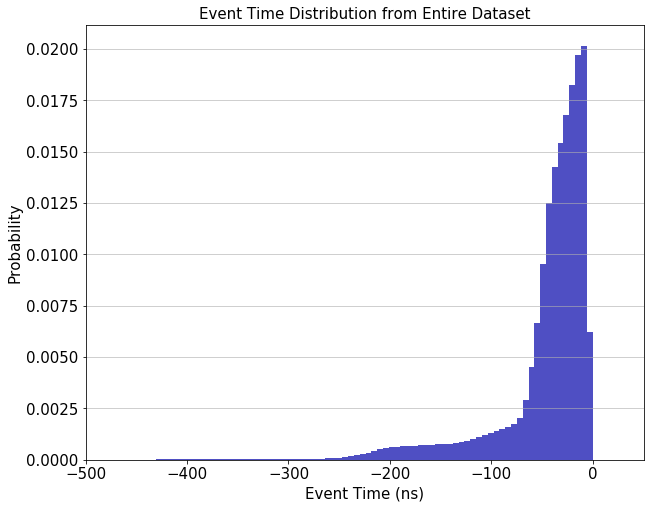

In [14]:

#What is the total energy distribution?
nbins=40
param_num=0
title='Vertex (x) Distribution from Entire Dataset'
xlabel='x (mm)'
ylabel='Probability'

hist,bin_edges=np.histogram(charge_params[:,param_num],bins=nbins,density=True)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
#plt.xlim(min(bin_edges), 10)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.rcParams["figure.facecolor"] = 'white'
plt.show()

#What is the total energy distribution?
nbins=40
param_num=1
title='Vertex (y) Distribution from Entire Dataset'
xlabel='y (mm)'
ylabel='Probability'

hist,bin_edges=np.histogram(charge_params[:,param_num],bins=nbins,density=True)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
#plt.xlim(min(bin_edges), 10)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.rcParams["figure.facecolor"] = 'white'
plt.show()

#What is the total energy distribution?
nbins=40
param_num=2
title='Vertex (z) Distribution from Entire Dataset'
xlabel='z (mm)'
ylabel='Probability'

hist,bin_edges=np.histogram(charge_params[:,param_num],bins=nbins,density=True)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
#plt.xlim(min(bin_edges), 10)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.rcParams["figure.facecolor"] = 'white'
plt.show()

#What is the total energy distribution?
nbins=40
param_num=3
title='Zenith Distribution from Entire Dataset'
xlabel='Zenith (rad)'
ylabel='Probability'

hist,bin_edges=np.histogram(charge_params[:,param_num],bins=nbins,density=True)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
#plt.xlim(min(bin_edges), 10)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.rcParams["figure.facecolor"] = 'white'
plt.show()

#What is the total energy distribution?
nbins=500
param_num=5
title='Event Time Distribution from Entire Dataset'
xlabel='Event Time (ns)'
ylabel='Probability'

hist,bin_edges=np.histogram(charge_params[:,param_num],bins=nbins,density=True)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
plt.xlim(-500, 50)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.rcParams["figure.facecolor"] = 'white'
plt.show()

In [78]:
from sibyl_cpp import snake
import numpy as np
#warning! doesnt check particle ID!

min_pmt_hits=0
events=[]
labels=['x','y','z','zenith','azimuth','t','energy']
sn = snake()
event_range=[]
for i in range(1,2):
    sn.openFile("/data/abald/no_noise/"+str(i)+".root")
    for event in range(0,sn.getEntries()):
        sn.getEvent(event)
        charges, times ,noise = sn.getHitInfo()
        PMT_id=sn.getID()
        pmts=np.where(charges>-100)[0] #get index of nonzero values
        if (len(pmts) > 0 and len(np.where(PMT_id[pmts]==1)[0]) > min_pmt_hits):
            sn.getMCTruth()
            x,y,z=sn.getXYZ()
            p=np.column_stack(sn.getMCVal())
            zenith = math.acos(p[0,5]/np.linalg.norm(p[0,3:6],2))
            azimuth = math.atan2(p[0,4], p[0,3])+3.141592654
            p=np.column_stack((p[0,0],p[0,1],p[0,2],zenith,azimuth,p[0,6],p[0,7]))
            new_params = np.repeat(p, len(pmts), axis=0)
            new_hits = np.column_stack((x[pmts],y[pmts],z[pmts],times[pmts],charges[pmts],PMT_id[pmts],noise[pmts]))
            
            data={
                "hits":  new_hits,
                "total_charge": [np.sum(new_hits[:,4]),len(new_hits)],
                "truth": p[0]   
            }
            events.append(data)
        if(event%10000==0):
            print(event)


    print(str(i)+" runs have been completed")

/data/abald/no_noise/1.root
0
10000
20000
30000
40000
50000
60000
70000


KeyboardInterrupt: 

In [20]:
len(events)
prm=[]
hit=[]
chg=[]
cprm=[]
print(len(events))
for event in events:
#    for i in range(0,len(event['hits'])):
#        hit.append(event['hits'][i])
#        prm.append(event['truth'][0])
    chg.append(event['total_charge'])
    cprm.append(event['truth'][0])
print('converted')
#np.save('/home/gmw5164/testbench/utilInstall/WMUtils/sibyl/noisedata/no_noise/hits.npy',np.array(hit))
#np.save('/home/gmw5164/testbench/utilInstall/WMUtils/sibyl/noisedata/no_noise/params.npy',np.array(prm))


9955899
converted


In [21]:
np.save('/home/gmw5164/testbench/utilInstall/WMUtils/sibyl/noisedata/no_noise/charge.npy',np.array(chg))
np.save('/home/gmw5164/testbench/utilInstall/WMUtils/sibyl/noisedata/no_noise/cparams.npy',np.array(cprm))

In [22]:
del events

In [79]:
x=events[0]['hits'][:,3]-events[0]['truth'][5]
for event in range(1,len(events)):
    x=np.hstack([events[event]['hits'][:,3]-events[event]['truth'][5],x])


1.0024545690900935


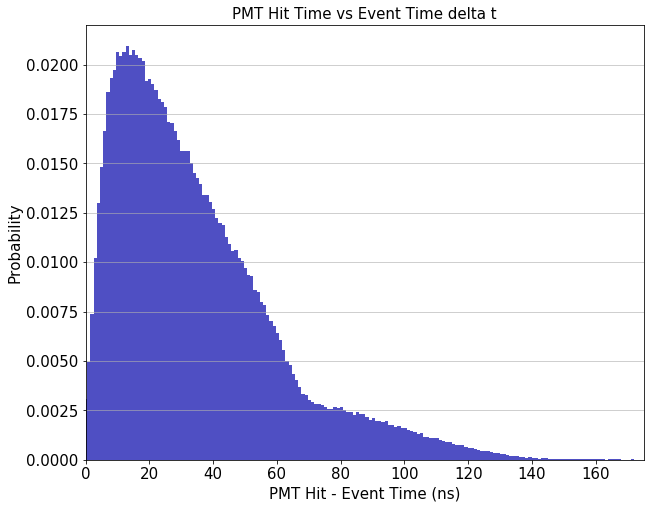

In [87]:

#What is the total energy distribution?
nbins=278
param_num=3
title='PMT Hit Time vs Event Time delta t'
xlabel='PMT Hit - Event Time (ns)'
ylabel='Probability'

hist,bin_edges=np.histogram(x,bins=nbins,density=True)
width=(np.max(bin_edges)-np.min(bin_edges))/nbins
plt.figure(figsize=[10,8])
print(width)
plt.bar(bin_edges[:-1], hist, width=width, color='#0504aa',alpha=0.7)
#plt.xlim(min(bin_edges), 10)
plt.grid(axis='y', alpha=0.75) 
plt.xlabel(xlabel,fontsize=15)
plt.yscale('linear')
plt.ylabel(ylabel,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(title,fontsize=15)
plt.rcParams["figure.facecolor"] = 'white'
plt.xlim(0, 175)
plt.show()


In [160]:
from scipy.optimize import least_squares

def get_residuals(x,event):
    #input vector x corresponds to [x,y,z,t]
    residuals=[]
    c=299792458*10**-6
    n=1.333
    #takes an event hit and calculates residuals
    for i in range (0,len(event['hits'])):
        hit=event['hits'][i]
        residuals.append((c/n)**2*(x[3]-hit[3])**2 - (x[0]-hit[0])**2 - (x[1]-hit[1])**2 - (x[2]-hit[2])**2)
    return np.array(residuals)

event=68
truth=events[event]['truth'][[0,1,2,5]]
#truth=np.array([0,0,0,0,0])
get_residuals(truth,events[event])

bound=([-6700,-6700,-6700,-400],[6700,6700,6700,400])

x0=np.array([0,0,0,-30])
returned=least_squares(get_residuals,x0,args=(events[event],),bounds=bound)
print(returned['x'])

print(truth)

print((returned['x'][0]**2+returned['x'][1]**2)**0.5)
print((truth[0]**2+truth[1]**2)**0.5)

print(events[event]['hits'])

[ 225.62355961  302.49104993 -195.21245894   34.83799961]
[ 382.38989466  802.37018842 1447.99392908  -37.4286229 ]
377.3682895277321
888.8306648639443
[[-3.77424439e+03 -5.53579979e+03  1.75000000e+03 -2.57731625e+00
   1.01159251e+00  1.00000000e+00 -1.00000000e+02]
 [-9.98583183e+02 -6.62516654e+03  3.75000000e+03 -1.00345312e+00
   9.00156498e-01  1.00000000e+00 -1.00000000e+02]
 [-1.49089026e+03 -6.53201701e+03  3.75000000e+03 -7.15037291e-01
   1.63725662e+00  1.00000000e+00 -1.00000000e+02]
 [-4.17738167e+03 -5.23827093e+03 -1.75000000e+03 -4.01684918e-01
   1.65219736e+00  1.00000000e+00 -1.00000000e+02]
 [-6.03649141e+03 -2.90702105e+03 -2.50000000e+02 -3.59873505e-02
   7.54394770e-01  1.00000000e+00 -1.00000000e+02]
 [-6.62516654e+03 -9.98583183e+02  5.25000000e+03  0.00000000e+00
   1.10972416e+00  1.00000000e+00 -1.00000000e+02]
 [-6.23685412e+03 -2.44778486e+03  1.25000000e+03  1.18490539e-01
   8.99827600e-01  1.00000000e+00 -1.00000000e+02]
 [ 4.55715734e+03 -4.91144754

In [155]:
event=68

def get_n9(event):
    index=np.argsort(event['hits'][:,3])
    event['hits']=event['hits'][index]#sort the pmts by time hit to make searching easier
#    print(event['hits'][:,3])
    window=[0,0,0]
    for i in range(0,len(event['hits'])):
        for j in range(i+4,len(event['hits'])):
            if event['hits'][j,3]-event['hits'][i,3]<9 and window[2]<j-i:
                if j-i>window[1]-window[0]:
                    window=[i,j,j-i]
    return window

print(events[event]['hits'][:,3])
n9s=get_n9(events[event])
print(n9s)

[-3.59873505e-02  1.03394277e+00  1.18490539e-01  1.81933686e-01
 -4.01684918e-01 -2.57731625e+00  8.74714277e-01  1.11332114e+00
  6.79777452e+01  1.71679252e-01  8.58238629e+00  7.30275677e+01
 -7.15037291e-01 -1.00345312e+00  8.00446224e+00  3.94360820e-01
  0.00000000e+00]
[0, 12, 12]


In [76]:
noise=[]
for event in events:
    for i in range(0,len(event['hits'])):
        noise.append(event['hits'][i,6])

In [77]:
noise

[-100.0,
 -100.0,
 -100.0,
 1.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 1.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 1.0,
 1.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 1.0,
 1.0,
 1.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 1.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 1.0,
 1.0,
 1.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 1.0,
 -100.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 1.0,
 -100.0,
 -100.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -100.0,
 1.0,
 -100.0,
 -100.0,
 -100.0,
 1.0,
 -100.0,
 1.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 1.0,
 -100.0,
 -100.0,
 -100.0,
 1.0,
 -100.0,
 1.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 1.0,
 1.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 1.0,
 -100.0,
 